<a href="https://colab.research.google.com/github/PopoviciuAndreea/TextMiningProject/blob/main/TextMiningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proiect Text Mining**

## **Companii Aeriene și Zboruri**

În cadrul acestui proiect am extras articole despre companiile aeriene și zborurile acestora din ultimi 10 ani folosind The Guardian API. De asemenea, cu ajutorul unui OpenAI API am extras informații structurate din cadrul articolelor și le-am analizat pentru a observa anumite tipare alături de modul în care companiile aeriene sunt percepute în media.

In [ ]:
!pip install requests
!pip install openai==0.28
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2


Importăm librariile necesare

In [ ]:
import requests
import json
from datetime import datetime
import sqlite3
import openai
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt

Pentru a selecta articolele cu ajutorul unui The Guardian API folosim următoarele criterii:


*   keywords - filtrăm articolele folosind cuvintele cheie "airlines flights" pentru a obține articole relevant pentru industria aviației care să se concentrează pe termeni precum "airline companies" și "flights"

*   from_date - pentru a obține o imagine pe termen lung a companiilor o să selectăm articolele din ultimi 10 ani începând cu 01/01/2014


*   to_date - ne dorim ca articolele să fie cât mai relevante pentru contextul pieței actuale, motiv pentru care o să selectăm articolele publicate până în data de 01/11/2024

*   page-size - am ales să extragem 200 de articole

In [ ]:
api_key = 'd9d58992-aa22-4361-9875-6b5310534e4c'

url = 'https://content.guardianapis.com/search'

keywords = 'airlines flights'
from_date = '2014-01-01'
to_date = '2024-11-01'
page_size = 200

params = {
    'api-key': api_key,
    'q': keywords,
    'from-date': from_date,
    'to-date': to_date,
    'page-size': page_size,
    'show-fields': 'all'
}

response = requests.get(url, params=params)

Dacă articolele au fost extrase cu succes acestea o să fie stocate într-un fișier cu format JSON

In [ ]:
if response.status_code == 200:
    data = response.json()

    articles = data['response']['results']

    article_list = []

    for article in articles:
        article_info = {
            'title': article['webTitle'],
            'url': article['webUrl'],
            'published_date': article['webPublicationDate'],
            'section': article['sectionName'],
            'fields': article['fields'] if 'fields' in article else {}
        }
        article_list.append(article_info)

    file_name = f"guardian_articles_{keywords.replace(' ', '_')}.json"

    with open(file_name, 'w') as json_file:
        json.dump(article_list, json_file, indent=4)

    print(f"Saved {len(article_list)} articles to {file_name}")

else:
    print(f"Error: Unable to fetch data (status code: {response.status_code})")


Saved 200 articles to guardian_articles_airlines_flights.json


Pentru a lucra mai ușor cu datele o să stocăm articolele din fișierul JSON într-o bază de date SQLite.

In [ ]:
db_name = 'guardian_articles.db'
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS articles (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        title TEXT,
        url TEXT,
        published_date TEXT,
        section TEXT,
        fields TEXT
    )
''')

json_file_name = '/content/guardian_articles_airlines_flights.json'
with open(json_file_name, 'r') as json_file:
    articles = json.load(json_file)

for article in articles:
    cursor.execute('''
        INSERT INTO articles (title, url, published_date, section, fields)
        VALUES (?, ?, ?, ?, ?)
    ''', (article['title'], article['url'], article['published_date'], article['section'], json.dumps(article['fields'])))

conn.commit()
conn.close()

print(f"Inserted {len(articles)} articles into the SQLite database.")

Inserted 200 articles into the SQLite database.


O să folosim API-ul OpenAI pentru a analiza articolele și a extrage informații structurate pe care o să le stocăm ulterior în baza de date.

În cadrul funcției de mai jos stocăm mai multe prompt-uri într-un dicționar. Acestea o să fie trimise la OpenAI pentru a analiza fiecare articol din baza de date.

Parametrul article_text reprezintă conținutul articolului care va fi analizat

Fiecare cheie din cadrul dicționarului va avea asociat un prompt care va fi folosit pentru a extrage informații specifice din cadrul articolelor.
*   *summary* - Solicită rezumatul articolului
*   *sentiment* - Solicită analiza sentimentului care reiese din cadrul articolului (pozitiv, negativ, sau neutru)
*   *keywords* - Extrage cuvintele cheie din articol
*   *departure_country , departure_city, departure_airport* - Identifică și extrage numele țări, orașului și al aeroportului menționate în articolului din care au decolat sau urmează să decoleze avioane
*   *arrival_country, arrival_city, arrival_airport* - Identifică și extrage numele țări, orașului și al aeroportului în care au aterizat sau urmează să aterizeze avioane
*   *company_name* - Identifică și extrage numele companiei aeriene care este menționată cel mai des în articol

În cazul în care una dintre informații nu este specificată solicităm modelului OpenAI să returneze ca și răspuns valoarea 'Not Specified'.







In [ ]:
def create_article_prompts(article_text):
    prompts = {
        "summary": f"Summarize the following article:\n{article_text}",
        "sentiment": f"Analyze the sentiment of this article (positive, negative, or neutral). Return just the sentiment.:\n{article_text}",
        "keywords": f"Extract the main keywords from this article. Return just the keywords:\n{article_text}",
        "departure_country": f"Identify the country name where the plane take off from the following article. Return just the name. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "departure_city": f"Identify the city name where the plane take off from the following article. Return just the name. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "departure_airport": f"Identify the name of the airport where the plane take off mentioned in this article. Return just the airport name. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "arrival_country": f"Identify the country name for the arrival location of the flight mentioned in this article. Return just the arrival location. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "arrival_city": f"Identify the city name for the arrival location of the flight mentioned in this article. Return just the arrival location. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "arrival_airport": f"Identify the name of the airport where the plane arrive mentioned in this article. Return just the name of the destionation airport. If it is not mentioned, return 'Not Specified'.:\n{article_text}",
        "company_name": f"Identify the airline company that is most often mentioned in the article. Return just the airline company name. If it is not mentioned, return 'Not Specified'.:\n{article_text}"
    }
    return prompts

Funcția get_response() trimite un prompt către modelul gpt-4o-mini și primește răspunsul generat de acesta

In [ ]:
def get_response(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You are an assistant that analyzes news articles about airlines flights."},
                  {"role": "user", "content": prompt}]
    )
    return response['choices'][0]['message']['content']


În cadrul bazei de date SQLite adăugăm 10 coloane noi, câte una pentru fiecare prompt, pentru a stoca informațiile pe care o să le extragem din fiecare articol.

In [ ]:
db_name = 'guardian_articles.db'
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.execute('''ALTER TABLE articles ADD COLUMN summary TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN sentiment TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN keywords TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN departure_country TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN departure_city TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN departure_airport TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN arrival_country TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN arrival_city TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN arrival_airport TEXT''')
cursor.execute('''ALTER TABLE articles ADD COLUMN company_name TEXT''')

conn.commit()
conn.close()

Ne conectăm la baza de date, extragem toate articolele care nu au fost analizate și le trimitem pe rând la API-ul ChatGPT cu ajutorul funcției get_response(). De asemenea, funcția get_response() returnează rezultatul analizei articolului de către modelul OpenAI pentru fiecare prompt.

In [ ]:
openai.api_key = ''

db_name = 'guardian_articles.db'
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

cursor.execute('SELECT id, fields FROM articles WHERE summary IS NULL')
articles = cursor.fetchall()

for article_id, fields_json in articles:
    fields = json.loads(fields_json)
    article_text = fields.get('bodyText', '')

    prompts = create_article_prompts(article_text)

    summary = get_response(prompts["summary"])
    sentiment = get_response(prompts["sentiment"])
    keywords = get_response(prompts["keywords"])
    departure_country = get_response(prompts["departure_country"])
    departure_city = get_response(prompts["departure_city"])
    departure_airport = get_response(prompts["departure_airport"])
    arrival_country = get_response(prompts["arrival_country"])
    arrival_city = get_response(prompts["arrival_city"])
    arrival_airport = get_response(prompts["arrival_airport"])
    company_name = get_response(prompts["company_name"])

    cursor.execute('''
        UPDATE articles
        SET summary = ?, sentiment = ?, keywords = ?, departure_country = ?, departure_city = ?, departure_airport = ?, arrival_country = ?, arrival_city = ?, arrival_airport = ?, company_name = ?
        WHERE id = ?
    ''', (summary, sentiment, keywords, departure_country, departure_city, departure_airport, arrival_country, arrival_city, arrival_airport, company_name, article_id))

conn.commit()
conn.close()

print(f"Updated {len(articles)} articles with new information.")

Updated 200 articles with new information.


Eliminăm cuvintele de legătură din cadrul coloanei 'keywords' folosind librăria nltk

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
database_path = '/content/guardian_articles.db'

In [ ]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

stop_words = set(stopwords.words('english'))

cursor.execute(f"SELECT id, keywords FROM articles")
rows = cursor.fetchall()

for row in rows:
    article_id = row[0]
    text = row[1]

    if text:
        word_tokens = word_tokenize(text)
        filtered_text = ' '.join(word for word in word_tokens if word.lower() not in stop_words)

        cursor.execute(f"UPDATE articles SET keywords = ? WHERE id = ?", (filtered_text, article_id))

conn.commit()
cursor.close()
conn.close()
print(f"Successfully removed stopwords from 'keywords' column.")

Successfully removed stopwords from 'keywords' column.


In [ ]:
pd.set_option('display.max_colwidth', 100)
conn = sqlite3.connect(database_path)

query = 'SELECT * FROM articles'
df = pd.read_sql_query(query, conn)

conn.close()

print(df)

      id  \
0      1   
1      2   
2      3   
3      4   
4      5   
..   ...   
195  196   
196  197   
197  198   
198  199   
199  200   

                                                                                                   title  \
0                                           Two US airlines suspend flights to Tel Aviv – as it happened   
1          Rex airlines enters voluntary administration with all flights between capital cities grounded   
2    New Australian aviation ombudsman could force airlines to pay cash compensation for delayed flights   
3                Airlines may have to disclose carbon impact of individuals’ flights under new UK policy   
4                              BBC’s Frank Gardner criticises airline after crawling to toilet on flight   
..                                                                                                   ...   
195             World leaders urge restraint in aftermath of Iran attack on Israel – what we know s

Deoarece în baza de date există diferite abrevieri pentru valorile din coloane am creat funcții pentru a actualiza valorile din coloanele departure_country, departure_airport și company_name.

In [ ]:
def update_departure_country(correct_value, value_to_update):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    update_query = """
    UPDATE articles
    SET departure_country = ?
    WHERE departure_country = ?;
    """
    cursor.execute(update_query, (correct_value, value_to_update))

    conn.commit()
    conn.close()

    print(f"Updated all occurrences of '{value_to_update}' to '{correct_value}' in departure_country column.")

def update_departure_airport(correct_value, value_to_update):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    update_query = """
    UPDATE articles
    SET departure_airport = ?
    WHERE departure_airport = ?;
    """
    cursor.execute(update_query, (correct_value, value_to_update))

    conn.commit()
    conn.close()

    print(f"Updated all occurrences of '{value_to_update}' to '{correct_value}' in departure_airport column.")

def update_company_name(correct_value, value_to_update):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    update_query = """
    UPDATE articles
    SET company_name = ?
    WHERE company_name = ?;
    """
    cursor.execute(update_query, (correct_value, value_to_update))

    conn.commit()
    conn.close()

    print(f"Updated all occurrences of '{value_to_update}' to '{correct_value}' in departure_airport column.")

Cu ajutorul celor trei funcții actualizăm baza de date pentru a menține consistența datelor.

Astfel, specificăm denumirea corectă și denumirea greșită pe care am vrea să o actualizăm pentru țara, aeroportul de origine al unui zbor sau numele companiei.

In [ ]:
update_departure_country("United Kingdom", "UK")
update_departure_country("United Kingdom", "Britain")

Updated all occurrences of 'UK' to 'United Kingdom' in departure_country column.
Updated all occurrences of 'Britain' to 'United Kingdom' in departure_country column.


In [ ]:
update_departure_airport("Sydney Airport", "Sydney")
update_departure_airport("Sydney Airport", "Sydney airport")
update_departure_airport("Manchester Airport", "Manchester airport")
update_departure_airport("Manchester Airport", "Manchester")

update_departure_airport("Heathrow Airport", "Heathrow")
update_departure_airport("Heathrow Airport", "London Heathrow")
update_departure_airport("London City Airport", "London")
update_departure_airport("London City Airport", "London City")

update_departure_airport("Birmingham airport", "Birmingham")
update_departure_airport("Perth Airport", "Perth")
update_departure_airport("Los Angeles International Airport", "Los Angeles")
update_departure_airport("Portland International Airport", "Portland Airport")
update_departure_airport("Cologne-Bonn airport", "Cologne-Bonn")

update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut Airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut-Rafic Hariri airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Rafik Hariri International Airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut-Rafic Hariri international airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut’s international airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut International Airport")
update_departure_airport("Beirut–Rafic Hariri International Airport", "Beirut")

Updated all occurrences of 'Sydney' to 'Sydney Airport' in departure_airport column.
Updated all occurrences of 'Sydney airport' to 'Sydney Airport' in departure_airport column.
Updated all occurrences of 'Manchester airport' to 'Manchester Airport' in departure_airport column.
Updated all occurrences of 'Manchester' to 'Manchester Airport' in departure_airport column.
Updated all occurrences of 'Heathrow' to 'Heathrow Airport' in departure_airport column.
Updated all occurrences of 'London Heathrow' to 'Heathrow Airport' in departure_airport column.
Updated all occurrences of 'London' to 'London City Airport' in departure_airport column.
Updated all occurrences of 'London City' to 'London City Airport' in departure_airport column.
Updated all occurrences of 'Birmingham' to 'Birmingham airport' in departure_airport column.
Updated all occurrences of 'Perth' to 'Perth Airport' in departure_airport column.
Updated all occurrences of 'Los Angeles' to 'Los Angeles International Airport' in

In [ ]:
update_company_name("Qantas Airways", "Qantas")
update_company_name("Qantas Airways", "Qantas Group")
update_company_name("EasyJet", "easyJet")
update_company_name("Rex Airlines", "Rex")
update_company_name("Delta Air Lines", "Delta")
update_company_name("Delta Air Lines", "Delta Airlines")
update_company_name("American Airlines", "American")

Updated all occurrences of 'Qantas' to 'Qantas Airways' in departure_airport column.
Updated all occurrences of 'Qantas Group' to 'Qantas Airways' in departure_airport column.
Updated all occurrences of 'easyJet' to 'EasyJet' in departure_airport column.
Updated all occurrences of 'Rex' to 'Rex Airlines' in departure_airport column.
Updated all occurrences of 'Delta' to 'Delta Air Lines' in departure_airport column.
Updated all occurrences of 'Delta Airlines' to 'Delta Air Lines' in departure_airport column.
Updated all occurrences of 'American' to 'American Airlines' in departure_airport column.


Afișam distribuția țărilor din care au decolat a zborurilor folosind un Bar Chart.

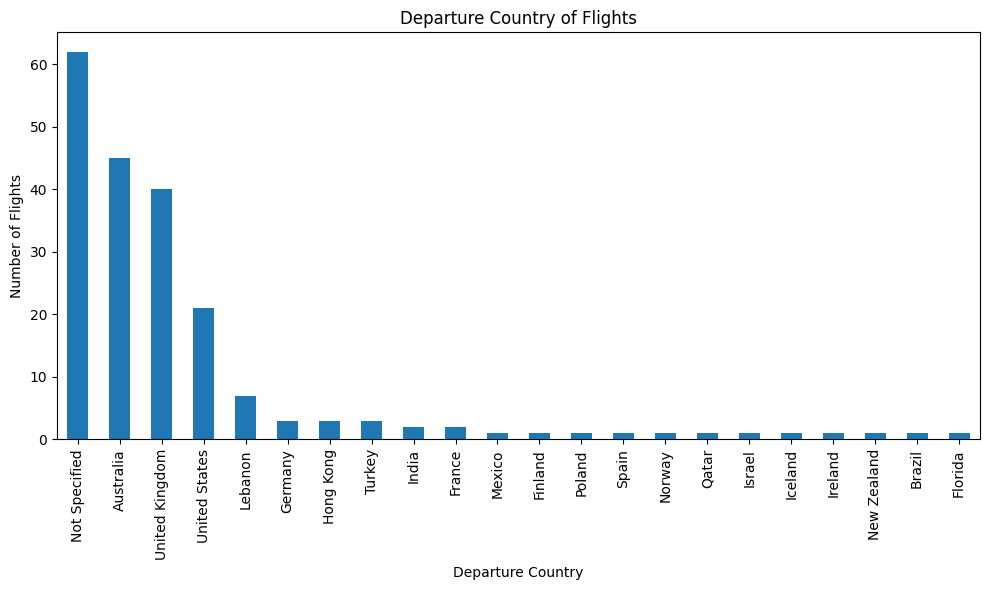

In [ ]:
departure_counts = df['departure_country'].value_counts()

plt.figure(figsize=(10, 6))
departure_counts.plot(kind='bar')
plt.title('Departure Country of Flights')
plt.xlabel('Departure Country')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Putem obserava că țara cel mai des menționată este Australia.

Afișăm distribuția aeroporturilor din care au decolat sau urmează să decoleze zboruri folosind un Bar Chart.

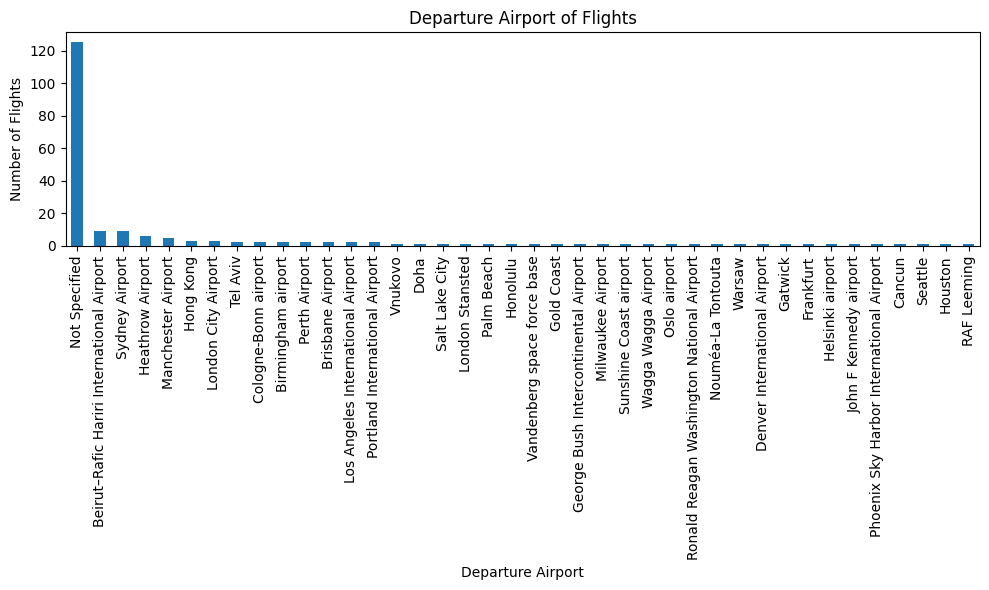

In [ ]:
departure_counts = df['departure_airport'].value_counts()

plt.figure(figsize=(10, 6))
departure_counts.plot(kind='bar')
plt.title('Departure Airport of Flights')
plt.xlabel('Departure Airport')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Putem observa că pentru peste 120 de articole nu s-a identificat numele aeroportului. De asemenea, numele cel mai des menționat este Beirut–Rafic Hariri International Airport, un aeroport din Liban urmat de "Sydney Airport", un aeroport din Australia.

Cu ajutorul unui Bar Chart putem vizualiza distribuția denumirilor companiilor aeriene menționate în articole.

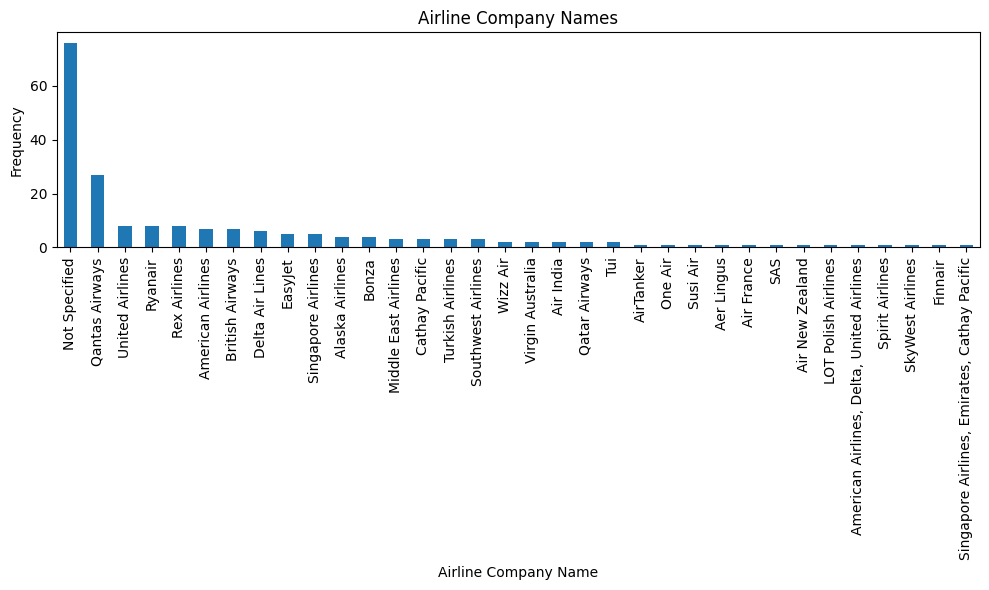

In [ ]:
company_counts = df['company_name'].value_counts()

plt.figure(figsize=(10, 6))
company_counts.plot(kind='bar')
plt.title('Airline Company Names')
plt.xlabel('Airline Company Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

Compania cel mai des menționată este Qantas Airways care este o companie aeriană din Australia.

Putem observa distribuția articolelor în funcție de sentiment cu ajutorul unui Pie Chart.

Astfel, avem 77.0% articole care au fost identificate de modelul OpenAI ca având un sentiment negativ, 14.0% articole cu un sentiment neutru și 9.0% articole cu un sentiment pozitiv.

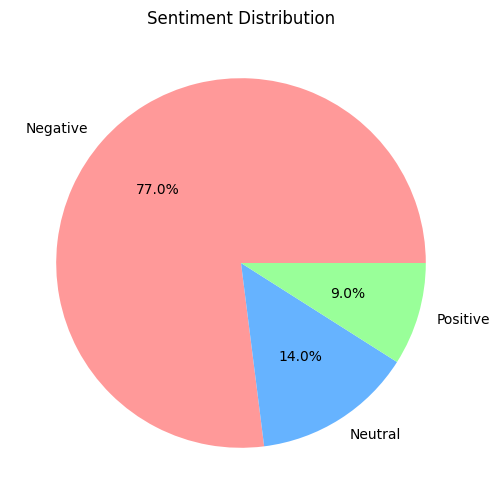

In [ ]:
plt.figure(figsize=(8,6))
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

Cu ajutorul funcției generate_and_execute_query() o să îî cerem modelului OpenAI gpt-4o-mini să genereze o interogare SQL bazată pe un prompt specific.

După ce interogarea este generată o să o executăm pe baza noastră de date SQLite și o să afișăm rezultatul obținut.

In [ ]:
def generate_and_execute_query(database_path, prompt):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    response = openai.ChatCompletion.create(
      model="gpt-4o-mini",
      messages=[{"role": "system", "content": "You are an expert in SQL querying."},
                {"role": "user", "content": prompt}],
      max_tokens=50
    )

    sql_query = response.choices[0].message['content'].strip()
    sql_query = sql_query.replace("```sql", "").replace("```", "").strip()

    print("Generated SQL Query:\n", sql_query)

    if sql_query.lower().startswith("select"):
        try:
            cursor.execute(sql_query)
            result = cursor.fetchall()

            for row in result:
                print("\n", row)
        except sqlite3.OperationalError as e:
            print("Error executing SQL query:", e)
    else:
        print("Generated text does not appear to be a SQL SELECT query.")

    conn.close()

Pentru a verifica dacă modelul OpenAI gpt-4o-mini a selectat corect numele țări și al aeroportului selectăm aeroporturile din care au decolat zboruri pentru care numele țări de origine este 'United Kingdom'.

In [ ]:
prompt = """
Write only a SQL query without any explanation. The query should select the distinct rows with departure country and departure airport columns
where the departure country is 'United Kingdom', from a table named `articles`.
"""
generate_and_execute_query(database_path, prompt)

Generated SQL Query:
 SELECT DISTINCT departure_country, departure_airport 
FROM articles 
WHERE departure_country = 'United Kingdom';

 ('United Kingdom', 'Not Specified')

 ('United Kingdom', 'London City Airport')

 ('United Kingdom', 'Heathrow Airport')

 ('United Kingdom', 'Manchester Airport')

 ('United Kingdom', 'Gatwick')

 ('United Kingdom', 'Beirut–Rafic Hariri International Airport')

 ('United Kingdom', 'London Stansted')

 ('United Kingdom', 'Birmingham airport')


Putem observa că toate aeroporturile sunt corect localizate în UK înafară de 'Beirut–Rafic Hariri International Airport' care este un aeroport din Liban.

Pentru a vedea cât de des se vorbește despre turbulențe în cadrul celor 200 de articole, selectăm Id-ul, titlul și data de publicare a articolelor care menționează cuvântul "turbulence".

In [ ]:
prompt = """
Write only a SQL query without any explanation. The query should select id, title, and published date columns
from a table named `articles`, where the word 'turbulence' appears in the `title`, `summary`, or `keywords` columns.
"""
generate_and_execute_query(database_path, prompt)

Generated SQL Query:
 SELECT id, title, published_date 
FROM articles 
WHERE title LIKE '%turbulence%' OR summary LIKE '%turbulence%' OR keywords LIKE '%turbulence%';

 (12, 'Severe turbulence injures seven people on United Airlines flight from Cancun', '2024-08-30T12:04:06Z')

 (13, 'Singapore Airlines offers $10,000 compensation to those injured in turbulence flight', '2024-06-11T04:00:35Z')

 (16, 'Briton who died on Singapore Airlines flight named as Geoffrey Kitchen', '2024-05-21T17:59:37Z')

 (29, '‘Sheer terror’: three Australians in intensive care after Singapore Airlines flight hit turbulence', '2024-05-23T03:54:00Z')

 (31, 'Singapore Airlines flight: British man dead and 30 injured after severe turbulence – as it happened', '2024-05-21T15:02:35Z')

 (42, '‘I feared for my life’: record-setting US traveler says he was held as possible spy', '2024-09-11T09:00:07Z')

 (77, 'Federal authorities investigate near-collision of two planes at Virginia airport', '2024-05-30T17:40:28Z'

Deoarece 'Singapore Airlines' este menționată în titlul a două dintre articolele care vorbesc despre turbulențe o să selectăm numărul de articole în care se menționează turbulențele iar compania cel mai des menționată în articol este "Singapore Airlines"

In [ ]:
prompt = """
Write only a SQL query without any explanation. The query should count the number of articles in a table named `articles`
where the word 'turbulence' appears in the `title`, `summary`, or `keywords` columns, and the `company_name` is 'Singapore Airlines'.
"""
generate_and_execute_query(database_path, prompt)

Generated SQL Query:
 SELECT COUNT(*) 
FROM articles 
WHERE (title LIKE '%turbulence%' OR summary LIKE '%turbulence%' OR keywords LIKE '%turbulence%') 
AND company_name = 'Singapore Airlines';

 (5,)


Putem observa că 'Singapore Airlines' este compania menționată în 5 dintre cele 12 articole care vorbesc despre turbulențe.

Selectăm numele companiei aeriene și numărul de articole în care este menționat cuvântul 'compensation'.

In [ ]:
prompt = """
Write only a SQL query without any explanation. The query should select the company name and the count of articles
where the word 'compensation' appears in the `title`, `summary`, or `keywords` columns, from a table named `articles`.
The result should be ordered by the count of the articles in descending order.
"""
generate_and_execute_query(database_path, prompt)

Generated SQL Query:
 SELECT company_name, COUNT(*) AS article_count
FROM articles
WHERE title LIKE '%compensation%' OR summary LIKE '%compensation%' OR keywords LIKE '%compensation%'
GROUP BY company_name
ORDER BY article_count DESC;

 ('Qantas Airways', 7)

 ('Not Specified', 5)

 ('Wizz Air', 1)

 ('United Airlines', 1)

 ('Singapore Airlines', 1)

 ('American Airlines', 1)
